In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
from torchvision.datasets import MNIST
import torchvision.transforms as T
import matplotlib.pyplot as plt
from IPython import display
from tqdm import tqdm

In [ ]:
plt.rcParams['figure.figsize'] = (11,11)
plt.rcParams['image.cmap'] = 'gray'

In [ ]:
# Dataset
mean = 0.1307
std = 0.3081
dataset = MNIST('data', transform=T.Compose([T.ToTensor(), T.Normalize((mean,), (std,))]), download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 36546605.90it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 86897915.23it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 47761021.23it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 14813785.98it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
from copy import deepcopy

class Scaled_Act(nn.Module):
    to_str = {'Sigmoid' : 'sigmoid', 'ReLU': 'relu', 'Tanh' : 'tanh', 'LeakyReLU': 'leaky_relu'}
    def __init__(self, act, scale = None):
        super().__init__()
        self.act = act
        act_name = Scaled_Act.to_str.get(act._get_name(), act._get_name())
        param = getattr(act, 'negative_slope', None)
        self.scale = scale if scale else torch.nn.init.calculate_gain(act_name, param)

    def forward(self, input):
        return self.scale*self.act(input)

class Equal_LR:
    def __init__(self, name):
        self.name = name

    def compute_norm(module, weight):
        mode = 'fan_in'
        if hasattr(module, 'transposed') and module.transposed:
            mode = 'fan_out'
        return torch.nn.init._calculate_correct_fan(weight, mode)


    def scale_weight(self, module, input):
        setattr(module, self.name, module.scale*module.weight_orig)


    def fn(self, module):
        try:
            weight = getattr(module, self.name)
            module.scale = 1/np.sqrt(Equal_LR.compute_norm(module, weight))
            if isinstance(weight, torch.nn.Parameter):
                # register new parameter -- unscaled weight
                module.weight_orig = nn.Parameter(weight.clone()/module.scale)
                # delete old parameter
                del module._parameters[self.name]
            else:
                # register new buffer -- unscaled weight
                module.register_buffer('weight_orig', weight.clone()/module.scale)
                # delete old buffer
                del module._buffers[self.name]
            module.equalize = module.register_forward_pre_hook(self.scale_weight)
        except:
            pass

    def __call__(self, module):
        new_module = deepcopy(module)
        new_module.apply(self.fn)
        return new_module



def parameters_to_buffers(m):
    params = m._parameters.copy()
    m._parameters.clear()
    for n,p in params.items():
        m.register_buffer(n, p.data)



def grid(array, ncols=8):
    array = np.pad(array, [(0,0),(1,1),(1,1),(0,0)], 'constant')
    nindex, height, width, intensity = array.shape
    ncols = min(nindex, ncols)
    nrows = (nindex+ncols-1)//ncols
    r = nrows*ncols - nindex # remainder
    # want result.shape = (height*nrows, width*ncols, intensity)
    arr = np.concatenate([array]+[np.zeros([1,height,width,intensity])]*r)
    result = (arr.reshape(nrows, ncols, height, width, intensity)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols, intensity))
    return np.pad(result, [(1,1),(1,1),(0,0)], 'constant')



class NextDataLoader(torch.utils.data.DataLoader):
    def __next__(self):
        try:
            return next(self.iterator)
        except:
            self.iterator = self.__iter__()
            return next(self.iterator)



def to_tensor(obj, device='cuda'):
    if obj.shape[-1] != 3 and obj.shape[-1] != 1:
        obj = np.expand_dims(obj,-1)
    if obj.ndim < 4:
        obj = np.expand_dims(obj,0)
    t = torch.tensor(np.moveaxis(obj,-1,-3), dtype=torch.float, device=device)
    return t


def to_img(obj):
    array = np.moveaxis(obj.data.cpu().numpy(),-3,-1)
    return array

In [ ]:
class Modulated_Conv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, latent_size,
                 demodulate=True, bias=True, stride=1, padding=0, dilation=1, **kwargs):
        super().__init__(in_channels, out_channels, kernel_size, stride,
                         padding, dilation, groups=1,
                         bias=bias, padding_mode='zeros')
        self.demodulate = demodulate
        # style mapping
        self.style = nn.Linear(latent_size, in_channels)
        # required shape might be different in transposed conv
        self.s_broadcast_view = (-1,1,self.in_channels,1,1)
        self.in_channels_dim = 2


    def convolve(self,x,w,groups):
        # bias would be added later
        return F.conv2d(x, w, None, self.stride, self.padding, self.dilation, groups=groups)


    def forward(self, x, v):
        N, in_channels, H, W = x.shape

        # new minibatch dim: (ch dims, K, K) -> (1, ch dims, K, K)
        w = self.weight.unsqueeze(0)

        # compute styles: (N, C_in)
        s = self.style(v) + 1

        # modulate: (N, ch dims, K, K)
        w = s.view(self.s_broadcast_view)*w

        # demodulate
        if self.demodulate:
            sigma = torch.sqrt((w**2).sum(dim=[self.in_channels_dim,3,4],keepdim=True) + 1e-8)
            w = w/sigma

        # reshape x: (N, C_in, H, W) -> (1, N*C_in, H, W)
        x = x.view(1, -1, H, W)

        # reshape w: (N, C_out, C_in, K, K) -> (N*C_out, C_in, K, K) for common conv
        #            (N, C_in, C_out, K, K) -> (N*C_in, C_out, K, K) for transposed conv
        w = w.view(-1, w.shape[2], w.shape[3], w.shape[4])

        # use groups so that each sample in minibatch has it's own conv,
        # conv weights are concatenated along dim=0
        out = self.convolve(x,w,N)

        # reshape back to minibatch.
        out = out.view(N,-1,out.shape[2],out.shape[3])

        # add bias
        if not self.bias is None:
            out += self.bias.view(1, self.bias.shape[0], 1, 1)

        return out


class Up_Mod_Conv(Modulated_Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, latent_size,
                 demodulate=True, bias=True, factor=2):
        assert (kernel_size % 2 == 1)
        padding = (max(kernel_size-factor,0)+1)//2
        super().__init__(in_channels, out_channels, kernel_size, latent_size, demodulate, bias,
                         stride=factor, padding=padding)
        self.output_padding = torch.nn.modules.utils._pair(2*padding - kernel_size + factor)
        # transpose as expected in F.conv_transpose2d
        self.weight = nn.Parameter(self.weight.transpose(0,1).contiguous())
        self.transposed = True
        # taking into account transposition
        self.s_broadcast_view = (-1,self.in_channels,1,1,1)
        self.in_channels_dim = 1

    def convolve(self, x, w, groups):
        return F.conv_transpose2d(x, w, None, self.stride, self.padding, self.output_padding, groups, self.dilation)


class Down_Mod_Conv(Modulated_Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, latent_size,
                 demodulate=True, bias=True, factor=2):
        assert (kernel_size % 2 == 1)
        padding = kernel_size//2
        super().__init__(in_channels, out_channels, kernel_size, latent_size, demodulate, bias,
                         stride=factor, padding=padding)

    def convolve(self, x, w, groups):
        return F.conv2d(x, w, None, self.stride, self.padding, self.dilation, groups=groups)


class Down_Conv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size,
                 bias=True, factor=2):
        assert (kernel_size % 2 == 1)
        padding = kernel_size//2
        super().__init__(in_channels, out_channels, kernel_size, factor, padding, bias=True)

    def convolve(self, x):
        return F.conv2d(x, w, None, self.stride, self.padding, self.dilation, self.groups)


class Noise(nn.Module):
    def __init__(self):
        super().__init__()
        self.noise_strength = nn.Parameter(torch.zeros(1))

    def forward(self, x, input_noise=None):
        if input_noise is None:
            input_noise = torch.randn(x.shape[0],1,x.shape[2],x.shape[3], device=x.device)
        noise = self.noise_strength*input_noise
        return x + noise

class Mapping(nn.Module):
    def __init__(self, n_layers, latent_size, nonlinearity, normalize=True):
        super().__init__()
        self.normalize = normalize
        self.layers = []
        for idx in range(n_layers):
            layer = nn.Linear(latent_size, latent_size)
            self.add_module(str(idx), layer)
            self.layers.append(layer)
            self.layers.append(nonlinearity)

    def forward(self, input):
        if self.normalize:
            input = input/torch.sqrt((input**2).mean(dim=1, keepdim=True) + 1e-8)
        for module in self.layers:
            input = module(input)
        return input


class G_Block(nn.Module):
    def __init__(self, in_fmaps, out_fmaps, kernel_size, latent_size, nonlinearity, factor=2, img_channels=3):
        super().__init__()
        inter_fmaps = (in_fmaps + out_fmaps)//2
        self.upconv = Up_Mod_Conv(in_fmaps, inter_fmaps, kernel_size, latent_size,
                                      factor=factor)
        self.conv = Modulated_Conv2d(inter_fmaps, out_fmaps, kernel_size, latent_size,
                                     padding=kernel_size//2)
        self.noise = Noise()
        self.noise2 = Noise()
        self.to_channels = Modulated_Conv2d(out_fmaps, img_channels, kernel_size=1,
                                      latent_size=latent_size, demodulate = False)
        self.upsample = nn.Upsample(scale_factor=factor, mode='bilinear', align_corners=False)
        self.act = nonlinearity

    def forward(self, x, v, y=None, input_noises=None):
        x = self.noise(self.upconv(x,v), None if (input_noises is None) else input_noises[:,0])
        x = self.act(x)
        x = self.noise2(self.conv(x,v), None if (input_noises is None) else input_noises[:,1])
        x = self.act(x)
        if not y is None:
            y = self.upsample(y)
        else:
            y = 0
        y = y + self.to_channels(x,v)
        return x, y

class D_Block(nn.Module):
    def __init__(self, in_fmaps, out_fmaps, kernel_size, nonlinearity, factor=2):
        super().__init__()
        inter_fmaps = (in_fmaps + out_fmaps)//2
        self.conv = nn.Conv2d(in_fmaps, inter_fmaps, kernel_size, padding=kernel_size//2)
        self.downconv = Down_Conv2d(inter_fmaps, out_fmaps, kernel_size, factor=factor)
        self.skip = Down_Conv2d(in_fmaps, out_fmaps, kernel_size=1, factor=factor)
        self.act = nonlinearity

    def forward(self, x):
        t = x
        x = self.conv(x)
        x = self.act(x)
        x = self.downconv(x)
        x = self.act(x)
        t = self.skip(t)
        return (x + t)/ np.sqrt(2)


class Minibatch_Stddev(nn.Module):
    def __init__(self, group_size=4):
        super().__init__()
        self.group_size = group_size

    def forward(self, x):
        s = x.shape
        t = x.view(self.group_size, -1, s[1], s[2], s[3])
        t = t - t.mean(dim=0, keepdim=True)
        t = torch.sqrt((t**2).mean(dim=0) + 1e-8)
        t = t.mean(dim=[1,2,3], keepdim=True) # [N/G,1,1,1]
        t = t.repeat(self.group_size,1,1,1).expand(x.shape[0],1,*x.shape[2:])
        return torch.cat((x,t),dim=1)

In [ ]:
def G_logistic_ns(fake_logits):
    return -F.logsigmoid(fake_logits).mean() # -log(D(G(z)))


def D_logistic(real_logits, fake_logits):
    return torch.mean(-F.logsigmoid(real_logits) + F.softplus(fake_logits)) # -log(D(x)) - log(1-D(G(z)))

def R1_reg(real_imgs, real_logits):
    grads = torch.autograd.grad(real_logits.sum(), real_imgs, create_graph=True)[0]
    return torch.mean((grads**2).sum(dim=[1,2,3]))

class Path_length_loss(nn.Module):
    def __init__(self, decay=0.01):
        super().__init__()
        self.decay = decay
        self.avg = 0

    def forward(self, dlatent, gen_out):
        # Compute |J*y|.
        noise = torch.randn(gen_out.shape, device=gen_out.device)/np.sqrt(np.prod(gen_out.shape[2:])) #[N,Channels,H,W]
        grads = torch.autograd.grad((gen_out * noise).sum(), dlatent, create_graph=True)[0]  #[N, num_layers, dlatent_size]
        lengths = torch.sqrt((grads**2).mean(2).sum(1)) #[N]
        # Update exp average. Lengths are detached
        self.avg = self.decay*torch.mean(lengths.detach()) + (1-self.decay)*self.avg
        return torch.mean((lengths - self.avg)**2)


def Noise_reg(noise_maps, min_res=8):
    loss = 0
    for nmap in noise_maps:
        res = nmap.shape[-1]
        while res > 8:
            loss += ( torch.mean(nmap * nmap.roll(shifts=1, dims=-1), dim=[-1,-2])**2
                    + torch.mean(nmap * nmap.roll(shifts=1, dims=-2), dim=[-1,-2])**2 ).sum()
            nmap = F.avg_pool2d(nmap.squeeze(), 2)
            res = res//2
    return loss

In [ ]:
class Generator(nn.Module):
    def __init__(self, min_res, max_res, min_fmaps, max_fmaps, act,
                 k_size, blocks, img_channels, latent_size, n_layers, style_mixing_prob = 0.8,
                 dlatent_avg_beta = 0.995, weights_avg_beta=0.99, **kwargs):
        super().__init__()
        dres = min_res*2**blocks - max_res
        assert dres >= 0
        # building mapping net
        self.latent_size = latent_size
        self.mapping = Mapping(n_layers, latent_size, act)
        # learnable const
        self.const = nn.Parameter(torch.randn(max_fmaps, min_res, min_res))
        # building main layers
        fmaps = np.linspace(max_fmaps, min_fmaps, blocks+1).astype('int')
        self.layers = []
        for i in range(blocks):
            layer = G_Block(fmaps[i],fmaps[i+1], k_size, latent_size, act, img_channels=img_channels)
            self.add_module(str(i), layer)
            self.layers.append(layer)
        if dres > 0:
            self.crop = torch.nn.ZeroPad2d(-dres//2)
        # style mixing
        self.style_mixing_prob = style_mixing_prob
        # running average of dlatents
        self.dlatent_avg_beta = dlatent_avg_beta
        self.register_buffer('dlatent_avg', torch.zeros(latent_size))
        # running average of weights
        self.weights_avg_beta = weights_avg_beta
        self.Src_Net = deepcopy(self).apply(parameters_to_buffers)
        self.Src_Net.train(False)


    # update running average of weights
    def update_avg_weights(self):
        params = dict(self.named_parameters())
        buffers = dict(self.named_buffers())
        for n,b in self.Src_Net.named_buffers():
            try:
                b.data.copy_(self.weights_avg_beta*b + (1-self.weights_avg_beta)*params[n])
            except:
                b.data.copy_(buffers[n])

    def load_avg_weights(self):
        buffers = dict(self.Src_Net.named_buffers())
        for n,p in self.named_parameters():
            p.data.copy_(buffers[n])


    # sample dlatents
    def sample_dlatents(self, n):
        v = self._sample_dlatents(n)
        if self.training and self.style_mixing_prob > 0:
            v = self._bcast_dlatents(v)
            l = len(self.layers)
            cut_off = torch.randint(l-1,())
            v2 = self._bcast_dlatents(self._sample_dlatents(n))
            mask = torch.empty(n, dtype=torch.bool).bernoulli_(self.style_mixing_prob).view(-1, 1) \
                   * (torch.arange(l)>cut_off)
            v = torch.where(mask.unsqueeze(-1).to(device=v.device), v2, v)
        return v

    def _sample_dlatents(self, n):
        device = self.const.device
        z = torch.randn(n, self.latent_size).to(device)
        v = self.mapping(z)
        # update dlatent average
        if self.training:
            self.dlatent_avg = self.dlatent_avg_beta*self.dlatent_avg + (1-self.dlatent_avg_beta)*v.data.mean(0)
        return v

    def _bcast_dlatents(self, v):
        # broadcast dlatents [N, dlatent_size] --> [N, num_layers, dlatent_size]
        return v.unsqueeze(1).expand(-1, len(self.layers), -1)


    # generate from dlatents and input noises (optionally)
    def generate(self, v, input_noises=None):
        x = self.const.expand(v.shape[0], *self.const.shape).contiguous()
        input_noises = input_noises if input_noises else [None]*len(self.layers)
        y = None
        if v.ndim < 3:
            v = self._bcast_dlatents(v)
        for i,layer in enumerate(self.layers):
            x, y = layer(x,v[:,i],y, input_noises[i])
        if hasattr(self, 'crop'):
            y = self.crop(y)
        return y


    # for training
    def sample(self, n):
        dlatents = self.sample_dlatents(n)
        x = self.generate(dlatents)
        return x


    # for evaluation
    def sample_images(self,n, truncation_psi=1):
        with torch.no_grad():
            v = self.Src_Net.sample_dlatents(n)
            # truncation trick
            if truncation_psi < 1:
                v = self.dlatent_avg + truncation_psi*(v-self.dlatent_avg)
            images = to_img(self.Src_Net.generate(v))
        return images

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, min_res, max_res, min_fmaps, max_fmaps, act,
                 k_size, blocks, img_channels, dense_size=128, **kwargs):
        super().__init__()
        assert max_res <= min_res*2**blocks and max_res >= (min_res-1)*2**blocks
        # building layers
        fmaps = np.linspace(min_fmaps, max_fmaps, blocks+1).astype('int')
        self.from_channels = nn.Conv2d(img_channels, fmaps[0], 1)
        self.layers = []
        for i in range(blocks):
            layer = D_Block(fmaps[i],fmaps[i+1], k_size, act)
            self.add_module(str(i), layer)
            self.layers.append(layer)
        self.minibatch_sttdev = Minibatch_Stddev()
        self.conv = nn.Conv2d(fmaps[-1]+1,fmaps[-1], 3)
        self.dense = nn.Linear(fmaps[-1]*(min_res-2)**2, dense_size)
        self.output = nn.Linear(dense_size, 1)
        self.act = act


    def get_score(self, imgs):
        x = self.act(self.from_channels(imgs))
        for layer in self.layers:
            x = layer(x)
        x = self.minibatch_sttdev(x)
        x = self.act(self.conv(x))
        x = x.view(x.shape[0],-1)
        x = self.act(self.dense(x))
        x = self.output(x)
        return x

In [ ]:
def train(G, D, dataset, max_iter, batch_size,
          G_opt_args, D_opt_args, mapping_opt_args,
          D_steps, pl_weight, r1_weight,
          r1_interval, pl_interval, val_interval, num_workers, pl_batch_part, checkpoint=None):

    pl_batch = int(pl_batch_part*batch_size)
    device = next(D.parameters()).device
    Path_length_reg = Path_length_loss()

    # create dataloader
    dataloader = NextDataLoader(dataset, batch_size, num_workers=num_workers)
    mean = dataset.transforms.transform.transforms[1].mean[0]
    std = dataset.transforms.transform.transforms[1].std[0]

    # load state
    if checkpoint:
        G.load_state_dict(checkpoint['G'])
        D.load_state_dict(checkpoint['D'])
        Path_length_reg.avg = checkpoint['pl_loss_avg']

    # create optimizer
    G_params = []
    for n,m in G.named_children():
        if n != 'mapping':
            G_params.extend(m.parameters())
    gen_optimizer = torch.optim.Adam([{'params': G_params},
                                  {'params': G.mapping.parameters(), **mapping_opt_args},
                                  {'params': G.const, **mapping_opt_args},
                                  ], **G_opt_args)
    disc_optimizer = torch.optim.Adam(D.parameters(), **D_opt_args)

    G.train()
    D.train()

    for i in tqdm(range(max_iter)):
        # discriminator update
        for j in range(D_steps):
            real_imgs = next(dataloader)[0].to(device)
            real_imgs.requires_grad = True
            fake_imgs = G.sample(real_imgs.shape[0])
            real_scores = D.get_score(real_imgs)
            fake_scores = D.get_score(fake_imgs)
            loss =  D_logistic(real_scores, fake_scores)
            if i % r1_interval == 0 and j == D_steps-1:
                loss += r1_weight*r1_interval*R1_reg(real_imgs, real_scores)
            real_imgs.requires_grad = False
            disc_optimizer.zero_grad()
            loss.backward()
            disc_optimizer.step()


        # generator update
        dlatent = G.sample_dlatents(batch_size)
        if i % pl_interval == 0:
            # hack to compute path length loss with smaller minibatch (for reducing memory consumption)
            dlatent_part1, dlatent_part_2 = dlatent[:pl_batch], dlatent[pl_batch:]
            fake_imgs = G.generate(torch.cat((dlatent_part1, dlatent_part_2), 0))
            fake_scores = D.get_score(fake_imgs)
            loss = G_logistic_ns(fake_scores) \
                   + pl_weight*pl_interval*Path_length_reg(dlatent_part1, fake_imgs[:pl_batch])
        else:
            fake_imgs = G.generate(dlatent)
            fake_scores = D.get_score(fake_imgs)
            loss = G_logistic_ns(fake_scores)
        gen_optimizer.zero_grad()
        loss.backward()
        gen_optimizer.step()
        # updating running average
        G.update_avg_weights()

        if i % val_interval == 0:
            display.clear_output(wait=True)
            # print pictures
            gen = G.sample_images(32)*std+mean
            plt.imshow(grid(gen).squeeze())
            plt.show()
            # print prob distribution
            plt.figure(figsize=(5,5))
            plt.title('Generated vs real data')
            plt.hist(torch.sigmoid(real_scores.data).cpu().numpy(), label='D(x)', alpha=0.5,range=[0,1])
            plt.hist(torch.sigmoid(fake_scores.data).cpu().numpy(), label='D(G(z))',alpha=0.5,range=[0,1])
            plt.legend(loc='best')
            plt.show()


        if i % (20*val_interval) == 0:
            torch.save({
                        'G': G.state_dict(),
                        'D': D.state_dict(),
                        'pl_loss_avg': Path_length_reg.avg.item()
                        }, 'checkpoint.pt')

In [ ]:
img_channels = 1
n_layers = 4  # number of layers in mapping from latents to dlatents
latent_size = 160 # for simplicity dim of latent space = dim of dlatent space

In [ ]:
min_res = 4 # resolution from which the synthesis starts
max_res = 28 # out resolution
blocks = 3 # number of building blocks for both the generator and dicriminator
k_size = 3 # convolutions kernel size
max_fmaps = 128 # number of feature maps at the beginning of generation
min_fmaps = 64  # number of feature maps before going to the number of channels

In [ ]:
weights_avg_beta=0.995 # beta for running average of generator weights
act = Scaled_Act(nn.LeakyReLU(0.2)) # activation function

In [ ]:
train_params = {
    'max_iter': 150,
    'batch_size' : 16,
    'G_opt_args' : {'lr' : 0.001, 'betas' : (0.1, 0.99)},
    'D_opt_args' : {'lr' : 0.001, 'betas' : (0, 0.99), 'eps' : 1e-08},
    'mapping_opt_args' : {'lr' : 1e-5},
    'D_steps': 1,
    'pl_weight': 2,
    'r1_weight': 8,
    'pl_batch_part': 0.5,
    'pl_interval': 4,
    'r1_interval': 16,
    'num_workers': 2,
    'val_interval': 20 }

In [ ]:
G = Generator(min_res, max_res, min_fmaps, max_fmaps, act,
              k_size, blocks, img_channels, latent_size, n_layers, weights_avg_beta=weights_avg_beta)

D = Discriminator(min_res, max_res, min_fmaps, max_fmaps, act,
                   k_size, blocks, img_channels)

In [ ]:
G = Equal_LR('weight')(G)
D = Equal_LR('weight')(D)

In [ ]:
def init_weights(m):
    if hasattr(m, 'weight_orig'):
        torch.nn.init.normal_(m.weight_orig)
    if hasattr(m, 'bias'):
        torch.nn.init.zeros_(m.bias)

G.apply(init_weights)
D.apply(init_weights)

Discriminator(
  (from_channels): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
  (0): D_Block(
    (conv): Conv2d(64, 74, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (downconv): Down_Conv2d(74, 85, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (skip): Down_Conv2d(64, 85, kernel_size=(1, 1), stride=(2, 2))
    (act): Scaled_Act(
      (act): LeakyReLU(negative_slope=0.2)
    )
  )
  (1): D_Block(
    (conv): Conv2d(85, 95, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (downconv): Down_Conv2d(95, 106, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (skip): Down_Conv2d(85, 106, kernel_size=(1, 1), stride=(2, 2))
    (act): Scaled_Act(
      (act): LeakyReLU(negative_slope=0.2)
    )
  )
  (2): D_Block(
    (conv): Conv2d(106, 117, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (downconv): Down_Conv2d(117, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (skip): Down_Conv2d(106, 128, kernel_size=(1, 1), stride=(2, 2))
    (act): Sc

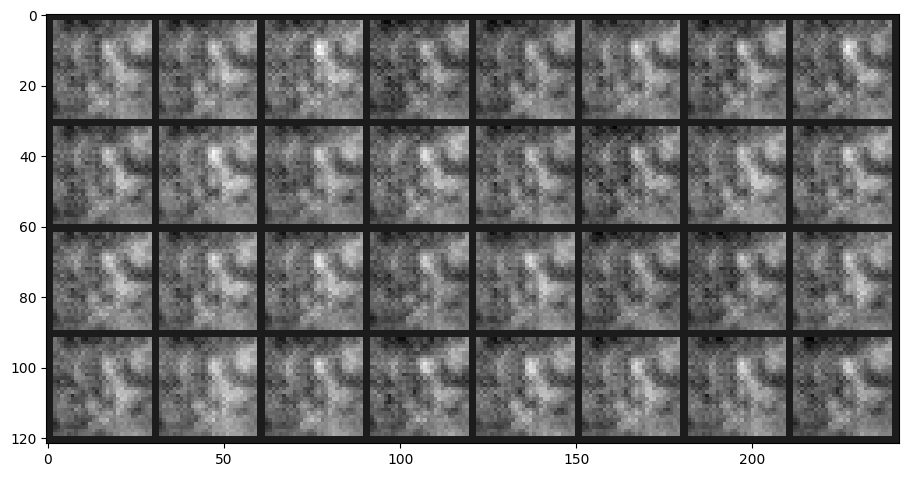

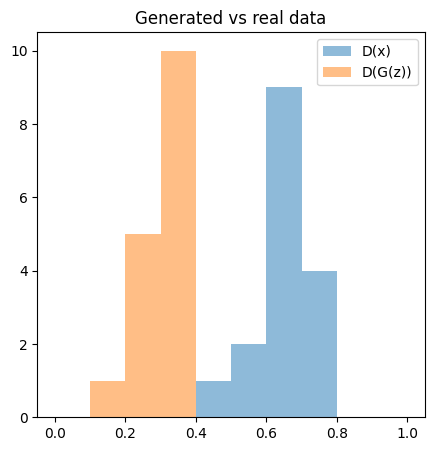

100%|██████████| 150/150 [05:27<00:00,  2.18s/it]


In [ ]:
train(G, D, dataset, **train_params)

In [ ]:
checkpoint = torch.load('checkpoint.pt')
G.load_state_dict(checkpoint['G'])
G.load_avg_weights()
G.eval();

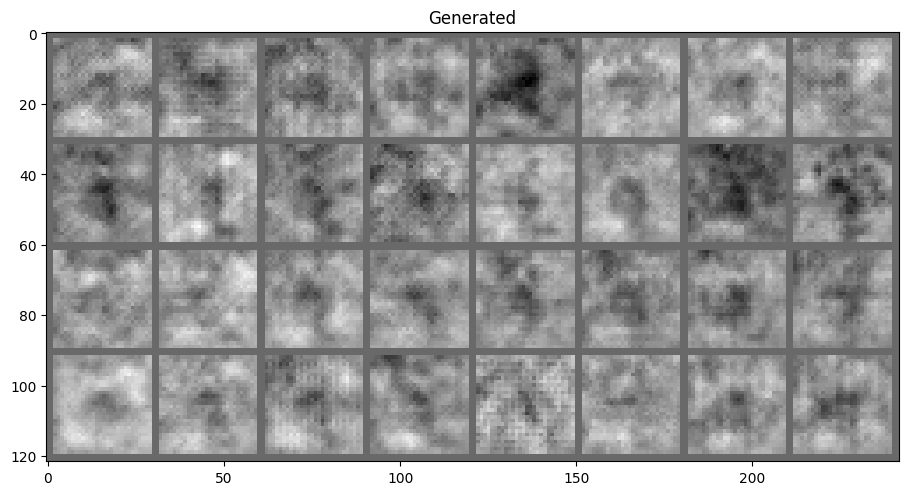

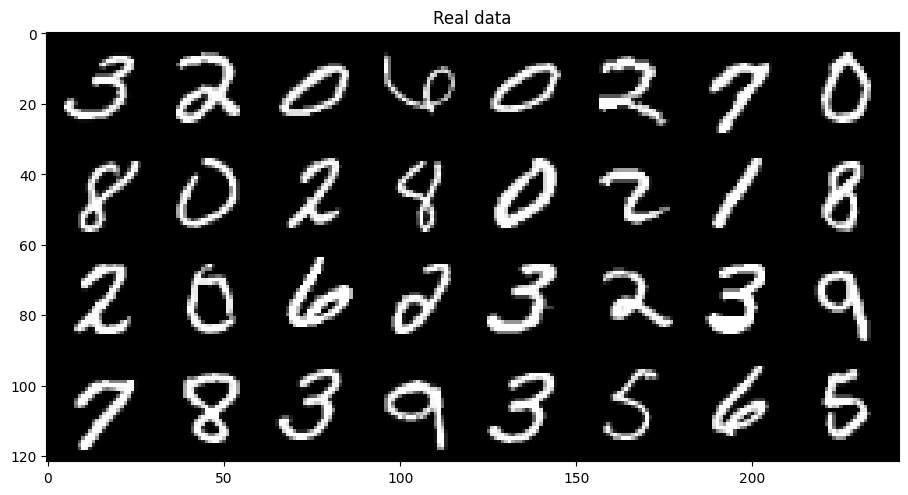

In [ ]:
plt.title('Generated')
plt.imshow(grid(G.sample_images(32, truncation_psi=0.9)*std+mean).squeeze())
plt.show()

plt.title('Real data')
i = np.random.randint(50000)
real_imgs = dataset.data[i:32+i].unsqueeze(-1)
plt.imshow(grid(real_imgs).squeeze())
plt.show()

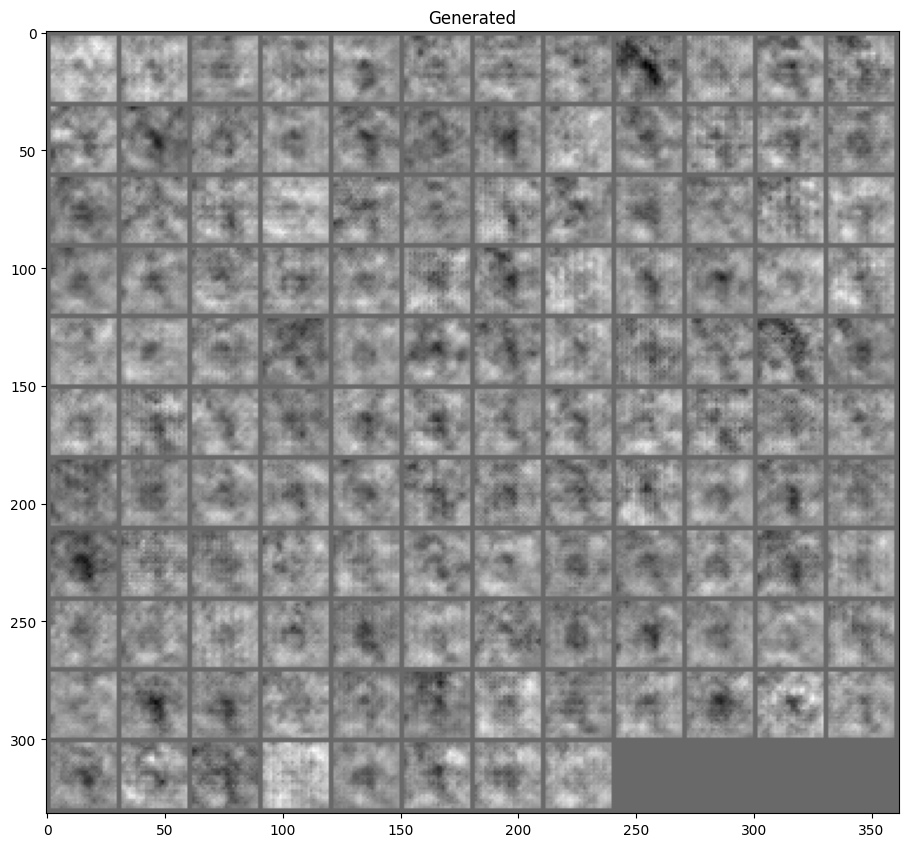

In [ ]:
plt.title('Generated')
#Compare affects of truncation value
plt.imshow(grid(G.sample_images(128, truncation_psi=0.9)*std+mean, ncols=12).squeeze())
plt.show()